In [1]:
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict 
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# fix the duplicate feature...
#%run ./dataFix.ipynb

In [3]:
# scores = pd.read_csv('C:\\Users\\rutad\\Documents\\bitbucket\\matlab\\robot_ranking_results_wConfidence.txt', delimiter='\t', lineterminator='\n', header=0)

# sortedScores = scores.sort_values("gif_id", ascending=[True])

# sortedScores = sortedScores[0:670]

motionData = pd.read_csv('motionData.csv', lineterminator='\n')
motionData.rename(columns={"FFPType\r": "FFPType"},inplace=True)
sortedScores = pd.read_csv('soretdScores.csv', lineterminator='\n')

In [4]:
# on ehot encoding for discrete features
enc = preprocessing.OneHotEncoder(n_values=[0,1,2, 3, 4,5,6])

In [5]:
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]

In [6]:
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression 

In [7]:
feature_def = gen_features(columns=[FEATURES],
                           classes=[preprocessing.StandardScaler])
# its a tuple and can't change it.. :(
# for (i, item) in enumerate(feature_def):
#     print(item)
#     if item[0] == "FFPType":
#         item[1] = preprocessing.OneHotEncoder()

# l = list(feature_def)
# l.append((['FFPType'], [preprocessing.OneHotEncoder]))

# allfeature_def = tuple(l)

In [8]:
#feature_def = gen_features(columns =[["FFPType"]], classes=[preprocessing.OneHotEncoder])

In [9]:
feature_def

[(['bodyAngleZ',
   'frontKneesAngle',
   'rearKneesAngle',
   'frontAnkle',
   'rearAnkle',
   'frontHipsAngle',
   'rearHipsAngle',
   'swingFtHeight',
   'speed',
   'gaitDuration'],
  [StandardScaler(copy=True, with_mean=True, with_std=True)])]

In [10]:
mapper = DataFrameMapper(feature_def,input_df =True, df_out=True)

In [11]:
motionDataScaled = mapper.fit_transform(motionData.copy())

In [12]:
 #mapper.transformed_names_

In [13]:
motionDataScaled.columns = FEATURES

In [14]:
#motionDataScaled

In [15]:
#mapperDiscrete = DataFrameMapper([(['FFPType'], preprocessing.OneHotEncoder)],input_df =True, df_out=True)
discfeature_def = gen_features(columns =[["FFPType"]], classes=[preprocessing.OneHotEncoder])
mapperDiscrete = DataFrameMapper(discfeature_def,input_df =True, df_out=True)

In [16]:
motionDataScaledFFP = mapperDiscrete.fit_transform(motionData.copy())

In [17]:
motionDataProcessedAllWithID = pd.concat([motionDataScaled,motionDataScaledFFP, motionData["id"]], axis = 1,join_axes=[motionDataScaled.index])
motionDataProcessedAll = pd.concat([motionDataScaled,motionDataScaledFFP], axis = 1,join_axes=[motionDataScaled.index])

In [18]:
motionDataProcessedAll.values.shape

(670, 17)

In [19]:
def featurize(features):
  transformations = [feature_def,
                     discfeature_def
                        ]

  return DataFrameMapper(filter(lambda x: x[0] in df.columns, transformations))

In [20]:
simple_pipeline = Pipeline([('featurize', featurize([FEATURESALL])), ('lm', LinearRegression())])

In [21]:
simple_pipeline

Pipeline(memory=None,
     steps=[('featurize', DataFrameMapper(default=False, df_out=False,
        features=<filter object at 0x1a0ff3e048>, input_df=False,
        sparse=False)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [22]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(motionDataProcessedAllWithID, sortedScores, test_size=0.2, random_state=42)

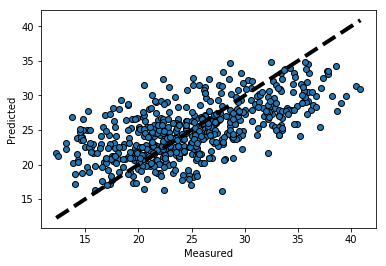

In [23]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
lr = LinearRegression()
lr.fit( X_train, y_train["happier_mu"])
predicted = cross_val_predict(lr, X_train, y_train["happier_mu"], cv=10)

fig, ax = plt.subplots()
ax.scatter(y_train["happier_mu"], predicted, edgecolors=(0, 0, 0))
ax.plot([y_train["happier_mu"].min(), y_train["happier_mu"].max()], [y_train["happier_mu"].min(), y_train["happier_mu"].max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [24]:
lr2 = LinearRegression()
lr2.fit(X_train, y_train["happier_mu"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

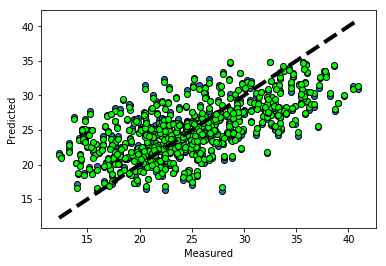

In [25]:
predictednoCV = lr2.predict(X_train)
fig, ax = plt.subplots()
ax.scatter(y_train["happier_mu"], predicted, edgecolors=(0, 0, 0))
ax.scatter(y_train["happier_mu"], predictednoCV, edgecolors=(0, 0, 0), color =(0,1,0))
ax.plot([y_train["happier_mu"].min(), y_train["happier_mu"].max()], [y_train["happier_mu"].min(), y_train["happier_mu"].max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [26]:
# The mean squared error
print("Mean squared error with CV (train): %.2f"
      % mean_squared_error(y_train["happier_mu"], predicted))
# Explained variance score: 1 is perfect prediction
print('Variance score with CV (train): %.2f' % r2_score(y_train["happier_mu"], predicted))

Mean squared error with CV (train): 22.24
Variance score with CV (train): 0.38


In [27]:
# The mean squared error
print("Mean squared error no CV (train): %.2f"
      % mean_squared_error(y_train["happier_mu"], predictednoCV))
# Explained variance score: 1 is perfect prediction
print('Variance score no CV (train): %.2f' % r2_score(y_train["happier_mu"], predictednoCV))

Mean squared error no CV (train): 20.84
Variance score no CV (train): 0.42


In [28]:
test_pred_nocv = lr2.predict(X_test)
test_pred_cv = lr.predict(X_test)

In [29]:
# The mean squared error
print("Mean squared error no CV (test): %.2f"
      % mean_squared_error( y_test["happier_mu"],test_pred_nocv))
# Explained variance score: 1 is perfect prediction
print('Variance score no CV (test): %.2f' % r2_score( y_test["happier_mu"],test_pred_nocv))

Mean squared error no CV (test): 18.48
Variance score no CV (test): 0.45


In [30]:
# The mean squared error
print("Mean squared error with CV (test): %.2f"
      % mean_squared_error(y_test["happier_mu"], test_pred_cv))
# Explained variance score: 1 is perfect prediction
print('Variance score with CV (test): %.2f' % r2_score( y_test["happier_mu"],test_pred_cv))

Mean squared error with CV (test): 18.48
Variance score with CV (test): 0.45
